## Setup

In [1]:
# import libraries
import pandas as pd
import numpy as np
import re
import random
import json
import networkx as nx
import torch
import torch.nn as nn
from torch.nn.functional import softplus
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from collections import defaultdict
import heapq
import time

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
all_losses = []
all_metrics = []
all_times = []
all_users = []
all_interactions = []

## Load, Filter, and Sample Data

In [117]:
# Load interactions data into a DataFrame
interactions_df = pd.read_json('/kaggle/input/goodreadspoetry/goodreads_interactions_poetry.json', lines=True)
books_df = pd.read_json('/kaggle/input/goodreadspoetry/goodreads_books_poetry.json', lines=True)

In [118]:
interactions_df.user_id.nunique()

377799

In [119]:
interactions_df.book_id.nunique()

36514

In [120]:
books_df.set_index('book_id', inplace=True)
book_names = books_df['title'].to_dict()

In [121]:
interactions_df.head()

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,1384,1bad0122cebb4aa9213f9fe1aa281f66,True,4,,Wed May 09 09:33:44 -0700 2007,Wed May 09 09:33:44 -0700 2007,,
1,8842281e1d1347389f2ab93d60773d4d,1376,eb6e502d0c04d57b43a5a02c21b64ab4,True,4,,Wed May 09 09:33:18 -0700 2007,Wed May 09 09:33:18 -0700 2007,,
2,8842281e1d1347389f2ab93d60773d4d,30119,787564bef16cb1f43e0f641ab59d25b7,True,5,,Sat Jan 13 13:44:20 -0800 2007,Wed Mar 22 11:45:08 -0700 2017,Tue Mar 01 00:00:00 -0800 1983,
3,72fb0d0087d28c832f15776b0d936598,24769928,8c80ee74743d4b3b123dd1a2e0c0bcac,False,0,,Wed Apr 27 11:05:51 -0700 2016,Wed Apr 27 11:05:52 -0700 2016,,
4,72fb0d0087d28c832f15776b0d936598,30119,2a83589fb597309934ec9b1db5876aaf,True,3,,Mon Jun 04 18:58:08 -0700 2012,Mon Jun 04 18:58:13 -0700 2012,,


In [122]:
# Drop columns
interactions = interactions_df.iloc[:, :5]
interactions.drop(columns=['review_id', 'is_read'], inplace=True)

# Keep only positive ratings (also removes 0's)
interactions = interactions[interactions_df['rating'] >= 3]

# Keep only users with 10 or more reviews
user_counts = interactions['user_id'].value_counts()
valid_users = user_counts[user_counts >= 10].index
interactions = interactions[interactions['user_id'].isin(valid_users)]

# Keep only books that appear 3 or more times
book_counts = interactions['book_id'].value_counts()
valid_books = book_counts[book_counts >= 3].index
interactions = interactions[interactions['book_id'].isin(valid_books)]

# Sample unique users
unique_users = interactions['user_id'].drop_duplicates().sample(min(5000, len(interactions)), random_state=42)
interactions = interactions[interactions['user_id'].isin(unique_users)]

print(len(interactions))
interactions.head()

116541


,user_id,book_id,rating
825,467ed8f03548be6c2d9228f9a2f7b2ea,28645638,4
826,467ed8f03548be6c2d9228f9a2f7b2ea,410739,5
827,467ed8f03548be6c2d9228f9a2f7b2ea,1232475,4
829,467ed8f03548be6c2d9228f9a2f7b2ea,22716470,5
830,467ed8f03548be6c2d9228f9a2f7b2ea,609155,5


In [123]:
interactions.user_id.nunique()

5000

## Mapping Ids to Continuous Integers

In [124]:
unique_users = interactions['user_id'].unique()
unique_books = interactions['book_id'].unique()

#--- Producing new continuous integer IDs for users and books
# Unique values : index
userid2idx = {o:i for i,o in enumerate(unique_users)}
bookid2idx = {o:i for i,o in enumerate(unique_books)}

# Obtained continuous ID for users and books
idx2userid = {i:o for o,i in userid2idx.items()}
idx2bookid = {i:o for o,i in bookid2idx.items()}

# return the id from the indexed values as noted in the lambda function down below.
interactions['book_id'] = interactions['book_id'].apply(lambda x: bookid2idx[x])
interactions['user_id'] = interactions['user_id'].apply(lambda x: userid2idx[x])

print(interactions.head())
print(interactions.user_id.nunique())
print(interactions.book_id.nunique())

     user_id  book_id  rating
825        0        0       4
826        0        1       5
827        0        2       4
829        0        3       5
830        0        4       5
5000
16673


## Train Test Split

In [125]:
# Create two DataFrames for the original interactions and the sample
train = pd.DataFrame()
test = pd.DataFrame()

# For each unique user_id, sample 20% of the interactions and remove them from the original dataframe
user_ids = interactions['user_id'].unique()
for user in user_ids:
    # Get all interactions for the current user
    user_interactions = interactions[interactions['user_id'] == user]

    # Sample 20% of the interactions
    sample = user_interactions.sample(frac=0.2, random_state=42)
    
    train = pd.concat([train, user_interactions.drop(sample.index)], ignore_index=True)
    test = pd.concat([test, sample], ignore_index=True)


# If there's a book_id in test that's not in train, move it from test to train
unique_test_books = set(test['book_id'])
unique_train_books = set(train['book_id'])

missing_in_train = unique_test_books.difference(unique_train_books)
if missing_in_train:
    for book_id in missing_in_train:
        # Get the rows from test with this book_id
        book_in_test = test[test['book_id'] == book_id]
        
        # Move those rows to train
        train = pd.concat([train, book_in_test], ignore_index=True)

        # Remove those rows from test
        test = test[test['book_id'] != book_id]


# Display the results
print("Training Data")
print(train.head())
print("Total rows in training data:", len(train))
print("Num Unique Users: ", train.user_id.nunique())

print("\nTesting Data")
print(test.head())
print("Total rows in testing data:", len(test))
print("Num Unique Users: ", test.user_id.nunique())

Training Data
   user_id  book_id  rating
0        0        2       4
1        0        3       5
2        0        4       5
3        0        5       3
4        0        6       5
Total rows in training data: 94838
Num Unique Users:  5000

Testing Data
   user_id  book_id  rating
0        0        0       4
1        0       17       5
2        0       15       5
3        0        1       5
5        1       36       5
Total rows in testing data: 21703
Num Unique Users:  4984


## Data Loader

In [126]:
# get negative samples
def data_loader(data, batch_size, n_usr, n_itm):
  
    interected_items_df = data.groupby('user_id')['book_id'].apply(list).reset_index()

    indices = [x for x in range(n_usr)]
    
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()
  
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id', right_on = 'users')
    
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id
  
    pos_items = interected_items_df['book_id'].apply(lambda x : random.choice(x)).values

    neg_items = interected_items_df['book_id'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

## Evaluation Metrics

In [127]:
def calculate_metrics(ground_truth, recommendations, K):
    # Recall@K
    def recall_at_k(ground_truth, recommendations, K):
        total_recall = 0
        num_users = len(ground_truth)
        for user in ground_truth:
            relevant_items = set(ground_truth[user])
            recommended_items = list(recommendations[user])  # Convert to list for slicing
            recall = len(relevant_items & set(recommended_items[:K])) / len(relevant_items)
            total_recall += recall
        return total_recall / num_users

    # Precision@K
    def precision_at_k(ground_truth, recommendations, K):
        total_precision = 0
        num_users = len(ground_truth)
        for user in ground_truth:
            relevant_items = set(ground_truth[user])
            recommended_items = list(recommendations[user])  # Convert to list for slicing
            precision = len(relevant_items & set(recommended_items[:K])) / K
            total_precision += precision
        return total_precision / num_users

    # NDCG@K
    def ndcg_at_k(ground_truth, recommendations, K):
        def dcg_at_k(recommended_items, relevant_items):
            dcg = 0
            for i, item in enumerate(recommended_items[:K]):
                if item in relevant_items:
                    dcg += 1 / np.log2(i + 2)  # Position-based weighting
            return dcg

        total_ndcg = 0
        num_users = len(ground_truth)
        for user in ground_truth:
            relevant_items = set(ground_truth[user])
            recommended_items = list(recommendations[user])[:K]  # Convert to list for slicing
            dcg = dcg_at_k(recommended_items, relevant_items)
            idcg = dcg_at_k(list(relevant_items), relevant_items)  # Ideal DCG
            if idcg > 0:
                total_ndcg += dcg / idcg
        return total_ndcg / num_users

    # MAP@K
    def map_at_k(ground_truth, recommendations, K):
        total_map = 0
        num_users = len(ground_truth)
        for user in ground_truth:
            relevant_items = set(ground_truth[user])
            recommended_items = list(recommendations[user])[:K]  # Convert to list for slicing
            if not relevant_items:
                continue
            precision_sum = 0
            relevant_count = 0
            for i, item in enumerate(recommended_items):
                if item in relevant_items:
                    relevant_count += 1
                    precision_sum += relevant_count / (i + 1)
            total_map += precision_sum / len(relevant_items)
        return total_map / num_users
    
    # Calculate the metrics
    metrics = {
        "Recall@K": recall_at_k(ground_truth, recommendations, K),
        "Precision@K": precision_at_k(ground_truth, recommendations, K),
        "NDCG@K": ndcg_at_k(ground_truth, recommendations, K),
        "MAP@K": map_at_k(ground_truth, recommendations, K),
    }
    
    return metrics

## Recommendation Generation

In [128]:
def generate_top_k_recommendations(model, user_id, n_items, K):
    # Create a tensor with all possible item indices
    item_indices = torch.arange(n_items, dtype=torch.long)

    # Create a tensor with the user ID repeated for each item
    user_tensor = torch.tensor([user_id] * n_items, dtype=torch.long)

    # Create a tensor for the user and item pairs
    user_item_pairs = torch.stack([user_tensor, item_indices], dim=1)

    # Predict interaction scores for all items for this user
    predictions = model(user_item_pairs).detach().numpy()

    # Get the top-K item indices with the highest predicted scores
    top_k_indices = heapq.nlargest(K, range(len(predictions)), key=lambda i: predictions[i])

    # Return the top-K item indices
    return top_k_indices

## Model and Training

In [129]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors) 
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors) 
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.item_factors.weight.data.uniform_(0, 0.05)
        
    def forward(self, data):
        # matrix multiplication
        users, items = data[:,0], data[:,1]
        return (self.user_factors(users)*self.item_factors(items)).sum(1)
    
    def predict(self, user, item):
        data = torch.tensor([[user, item]], dtype=torch.long)
        return self.forward(data)

In [130]:
n_users = len(interactions['user_id'].unique())
n_items = len(interactions['book_id'].unique())
model = MatrixFactorization(n_users, n_items, n_factors=64)

num_epochs = 40
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
K = 10

val_metrics = []
loss_list_epoch = []

# get ground truth for validation
ground_truth = defaultdict(list)
for _, row in test.iterrows():
    user_id = row['user_id']
    book_id = row['book_id']
    ground_truth[user_id].append(book_id)

start_time = time.time()
    
for idx in range(num_epochs):
    n_batch = int(len(train) / batch_size)
    
    final_loss_list = []
    
    for batch_idx in range(n_batch):
        optimizer.zero_grad()
        users, pos_items, neg_items = data_loader(train, batch_size, n_users, n_items)
 
        # Convert user and item indices to LongTensor
        users_tensor = torch.tensor(users, dtype=torch.long)
        pos_items_tensor = torch.tensor(pos_items, dtype=torch.long)
        neg_items_tensor = torch.tensor(neg_items, dtype=torch.long)

        # Calculate interaction scores 
        pos_scores = model.forward(torch.stack([users_tensor, pos_items_tensor], dim=1))
        neg_scores = model.forward(torch.stack([users_tensor, neg_items_tensor], dim=1))

        # Calculate BPR loss (softplus ensures positive scores are higher than negative scores)
        loss = torch.mean(softplus(neg_scores - pos_scores))
        
        loss.backward()  
        optimizer.step()

        final_loss_list.append(loss.item())
    
    avg_loss = sum(final_loss_list) / len(final_loss_list)
    loss_list_epoch.append(avg_loss)
    
    if (idx + 1) % 4 == 0:
        # Evaluation
        user_recommendations = {}
        for user_id in test['user_id'].unique():
            top_k_items = generate_top_k_recommendations(model, user_id, n_items, K)
            user_recommendations[user_id] = top_k_items

        metrics = calculate_metrics(ground_truth, user_recommendations, K)
        val_metrics.append(metrics)
        
        print(f"Epoch {idx + 1}: Loss = {avg_loss:.4f}")
        if (idx + 1) % 4 == 0:
            for metric_name, metric_value in metrics.items():
                print(f"{metric_name}: {metric_value:.4f}")
        print()
            
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 4: Loss = 0.6311
Recall@K: 0.1267
Precision@K: 0.0387
NDCG@K: 0.0943
MAP@K: 0.0548

Epoch 8: Loss = 0.5519
Recall@K: 0.1263
Precision@K: 0.0386
NDCG@K: 0.0955
MAP@K: 0.0562

Epoch 12: Loss = 0.5107
Recall@K: 0.1259
Precision@K: 0.0386
NDCG@K: 0.0954
MAP@K: 0.0561

Epoch 16: Loss = 0.4919
Recall@K: 0.1259
Precision@K: 0.0386
NDCG@K: 0.0942
MAP@K: 0.0548

Epoch 20: Loss = 0.4831
Recall@K: 0.1276
Precision@K: 0.0389
NDCG@K: 0.0947
MAP@K: 0.0550

Epoch 24: Loss = 0.4800
Recall@K: 0.1260
Precision@K: 0.0386
NDCG@K: 0.0942
MAP@K: 0.0548

Epoch 28: Loss = 0.4773
Recall@K: 0.1259
Precision@K: 0.0386
NDCG@K: 0.0942
MAP@K: 0.0548

Epoch 32: Loss = 0.4769
Recall@K: 0.1259
Precision@K: 0.0386
NDCG@K: 0.0954
MAP@K: 0.0561

Epoch 36: Loss = 0.4748
Recall@K: 0.1258
Precision@K: 0.0385
NDCG@K: 0.0941
MAP@K: 0.0548

Epoch 40: Loss = 0.4743
Recall@K: 0.1259
Precision@K: 0.0385
NDCG@K: 0.0941
MAP@K: 0.0548

Total training time: 6082.82 seconds


## Plots

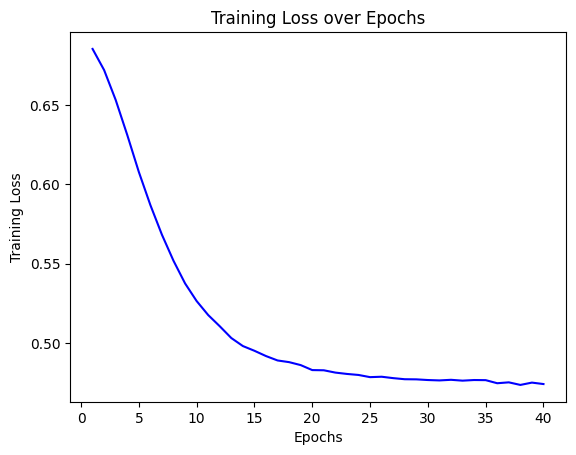

In [131]:
plt.plot(range(1, len(loss_list_epoch) + 1), loss_list_epoch, 'b-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.show()

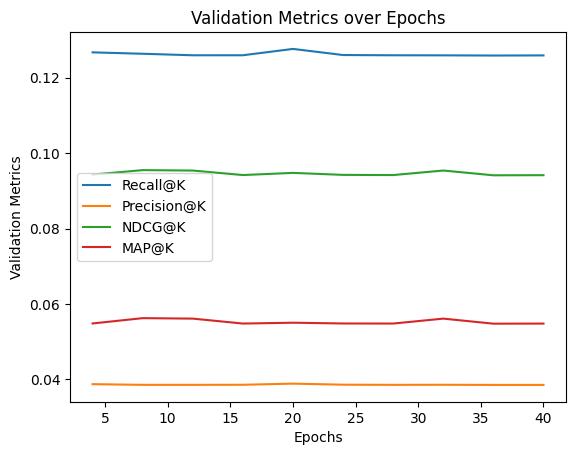

In [132]:
epochs_val = range(4, 4 * (len(val_metrics) + 1), 4)  # Assuming evaluation every 4 epochs

metric_keys = val_metrics[0].keys()  # Get the metric names
for key in metric_keys:
    metric_values = [metrics.get(key, 0) for metrics in val_metrics]
    plt.plot(epochs_val, metric_values, label=key)

plt.xlabel('Epochs')
plt.ylabel('Validation Metrics')
plt.title('Validation Metrics over Epochs')
plt.legend()

In [133]:
all_losses.append(loss_list_epoch)
all_metrics.append(val_metrics)
all_times.append(total_training_time)
all_users.append(n_users)
all_interactions.append(len(interactions))

In [134]:
print(all_losses[3][-1])

0.44182649840434046


In [135]:
print(all_metrics[3][-1])

{'Recall@K': 0.12784667407592176, 'Precision@K': 0.03821356615177934, 'NDCG@K': 0.09615396295594925, 'MAP@K': 0.057294069094063316}


In [136]:
print(all_times)

[8.068971872329712, 94.21105980873108, 320.580370426178, 2348.2855308055878, 6082.815326452255]


In [137]:
print(all_users)

[100, 500, 1000, 3000, 5000]


In [138]:
print(all_interactions)

[2711, 12386, 24152, 71367, 116541]


In [139]:
import pickle

# Create a dictionary with your data
data = {
    "all_losses": all_losses,
    "all_metrics": all_metrics,
    "all_times": all_times,
    "all_users": all_users,
    "all_interactions": all_interactions
}

# Save the dictionary to a Pickle file in the working directory
with open("/kaggle/working/saved_MF_data.pkl", "wb") as f:
    pickle.dump(data, f)